<a href="https://colab.research.google.com/github/ShirinHatam/FashionMnist_PytorchLib/blob/main/FashionMnist_PytorchLib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


 # Define and train the model




In [ ]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


dataset = FashionMNIST(root='data', train=True, transform=ToTensor(), download=True)
test_dataset = FashionMNIST(root='data', train=False, transform=ToTensor(), download=True)


num_train = int(0.9 * len(dataset))
num_val = len(dataset) - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


model.load_state_dict(torch.load('best_model.pth'))
model.eval()


test_loss = 0.0
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_acc = correct / total

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)





Test Loss: 0.2334219288033775
Test Accuracy: 0.9177


# conf matrix and classification report

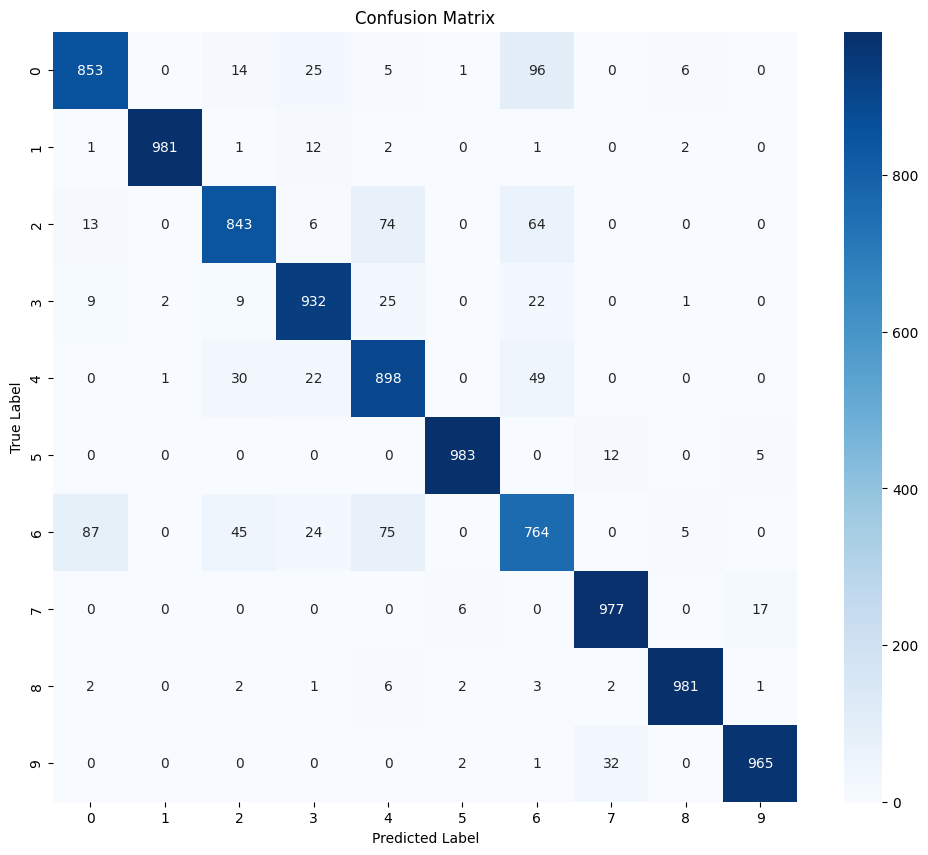

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.88      0.85      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.89      0.84      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.83      0.90      0.86      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.76      0.76      0.76      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


#  load and preprocess the image from a URL

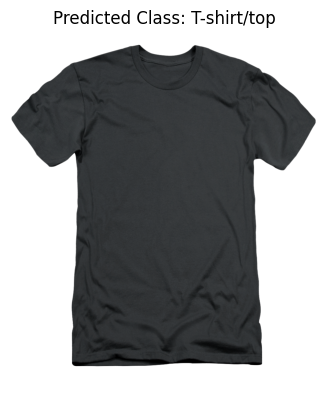

In [ ]:
# Function to load and preprocess the image from a URL
def load_and_preprocess_image_from_url(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image.resize((28, 28))
    image = image.convert('L')  # Convert to grayscale
    image = np.array(image)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=1)  # Add channel dimension
    return torch.tensor(image, dtype=torch.float32)

# Function to get the class name from the predicted class index
def get_class_name(class_index):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return class_names[class_index]

# URL of the image you want to predict
image_url = 'https://render.fineartamerica.com/images/images-clothing-body-styles/23-5.png'
# Load and preprocess the image from the URL
image = load_and_preprocess_image_from_url(image_url).to(device)

# Use the model to predict the class
predicted_probs = model(image)
predicted_class_index = predicted_probs.argmax().item()
predicted_class_name = get_class_name(predicted_class_index)

# Display the image along with the predicted class
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

plt.imshow(img, cmap='gray')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()
